# ECG Arrhythmia Classification


## 📋 Project Overview

This notebook presents our final working prototype for automatic ECG arrhythmia classification using deep learning. We developed a CNN-LSTM hybrid model trained on the MIT-BIH Arrhythmia Database.

### 🎯 Objectives
- Classify ECG signals into 5 arrhythmia classes
- Achieve >90% F1 macro score
- Address extreme class imbalance through data augmentation
- Build robust deep learning pipeline

### 📊 Key Results
- **Test Accuracy:** 98.5%
- **F1 Score (macro):** 0.924
- **Status:** ✅ Target exceeded (0.90)

# Imports (Code)

In [4]:
import os
import time
import warnings
warnings.filterwarnings('ignore')

# Data processing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import joblib

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

print("✓ All libraries imported")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ All libraries imported
PyTorch version: 2.7.1+cpu
CUDA available: False


## 1. Dataset: MIT-BIH Arrhythmia Database

The MIT-BIH Arrhythmia Database contains ECG recordings from 47 subjects. Each heartbeat is labeled into one of 5 categories:

| Class | Description | Original Count | Challenge | Clinical Significance |
|-------|-------------|----------------|-----------|-----------------------|
| **0 - Normal** | Normal beat | 61,600 | Majority class | Baseline rhythm |
| **1 - Supraventricular** | Supraventricular ectopic beat | 1,889 | Minority (3% of Normal) | Common arrhythmia, usually benign |
| **2 - Ventricular** | Ventricular ectopic beat | 4,920 | Minority (8% of Normal) | Potentially life-threatening |
| **3 - Fusion** | Fusion beat | 545 | **Smallest** (0.9% of Normal) | Rare, complex rhythm |
| **4 - Unknown** | Unknown beat | 5,466 | Minority (9% of Normal) | Quality control category |

**Total samples:** 74,420 (train) + 21,892 (test)

### ⚠️ Key Challenge: Extreme Class Imbalance
The imbalance ratio is 1:113 (Fusion vs Normal), making this a challenging multi-class classification problem.

In [5]:
# Download from Kaggle (uncomment and configure kaggle API if needed)
# !kaggle datasets download -d shayanfazeli/heartbeat -p . --unzip

# Load data
print("Loading MIT-BIH dataset...")
train_df = pd.read_csv('data/mitbih_train.csv', header=None)
test_df = pd.read_csv('data/mitbih_test.csv', header=None)

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

# Separate features and labels
X_train_full = train_df.iloc[:, :-1].values
y_train_full = train_df.iloc[:, -1].values.astype(int)
X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values.astype(int)

# Split train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.15,
    stratify=y_train_full,
    random_state=42
)

print(f"\nTrain: {len(X_train):,} | Val: {len(X_val):,} | Test: {len(X_test):,}")

# Reshape for CNN (batch, channels, length)
X_train = X_train.reshape(-1, 1, 187)
X_val = X_val.reshape(-1, 1, 187)
X_test = X_test.reshape(-1, 1, 187)

# Normalize data
print("\nNormalizing data...")
scaler = StandardScaler()
X_train_flat = X_train.reshape(-1, 187)
X_train = scaler.fit_transform(X_train_flat).reshape(-1, 1, 187)
X_val = scaler.transform(X_val.reshape(-1, 187)).reshape(-1, 1, 187)
X_test = scaler.transform(X_test.reshape(-1, 187)).reshape(-1, 1, 187)

os.makedirs('models', exist_ok=True)
joblib.dump(scaler, 'models/scaler.pkl')
print("✓ Scaler saved to models/scaler.pkl")
print(f"After normalization - Min: {X_train.min():.4f}, Max: {X_train.max():.4f}")

# Visualize class distribution
class_names = ['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unknown']
print("\n📊 Original Class Distribution:")
for i, name in enumerate(class_names):
    print(f"  {name}: {(y_train == i).sum():,}")

Loading MIT-BIH dataset...
Train shape: (87554, 188)
Test shape: (21892, 188)

Train: 74,420 | Val: 13,134 | Test: 21,892

Normalizing data...
✓ Scaler saved to models/scaler.pkl
After normalization - Min: -3.6961, Max: 31.3264

📊 Original Class Distribution:
  Normal: 61,600
  Supraventricular: 1,889
  Ventricular: 4,920
  Fusion: 545
  Unknown: 5,466


# Original Class Distribution

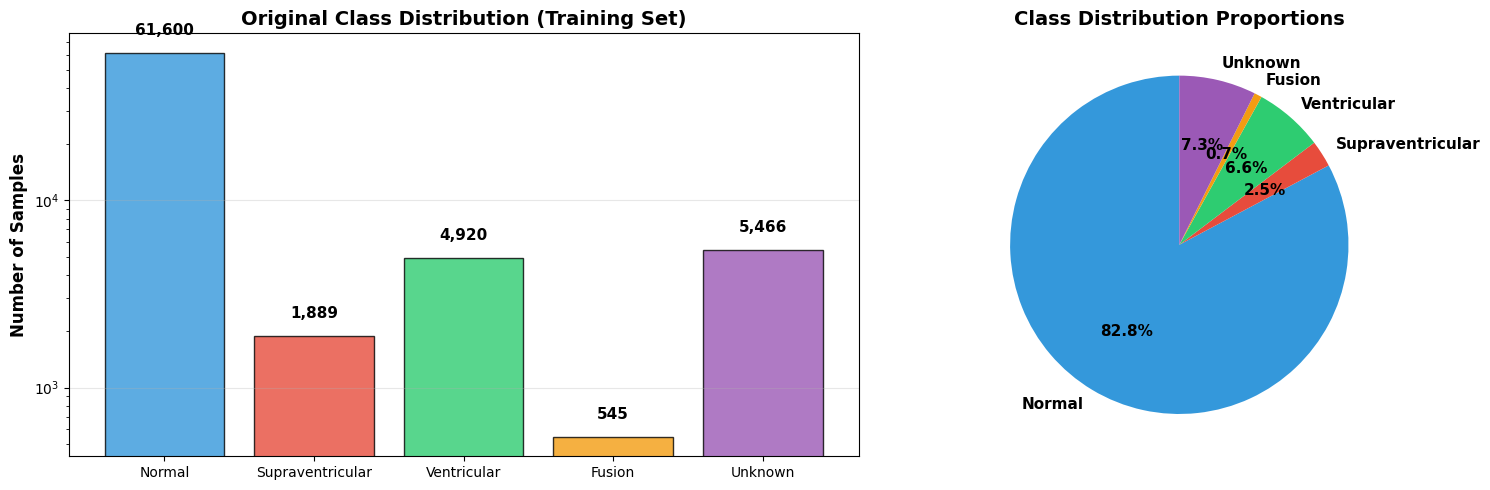


⚠️ Imbalance Ratio:
  Normal : Supraventricular = 32.6:1
  Normal : Ventricular = 12.5:1
  Normal : Fusion = 113.0:1
  Normal : Unknown = 11.3:1


In [6]:
# Analyze original class distribution
class_names = ['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unknown']
original_counts = np.bincount(y_train)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Bar chart
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
bars = ax1.bar(class_names, original_counts, color=colors, alpha=0.8, edgecolor='black')
ax1.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax1.set_title('Original Class Distribution (Training Set)', fontsize=14, fontweight='bold')
ax1.set_yscale('log')
ax1.grid(axis='y', alpha=0.3)

# Add values on bars
for bar, count in zip(bars, original_counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height * 1.2,
             f'{count:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Pie chart
ax2.pie(original_counts, labels=class_names, autopct='%1.1f%%',
        colors=colors, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax2.set_title('Class Distribution Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n⚠️ Imbalance Ratio:")
for i, name in enumerate(class_names):
    if i > 0:
        ratio = original_counts[0] / original_counts[i]
        print(f"  Normal : {name} = {ratio:.1f}:1")

# Visualize Sample ECG Signals

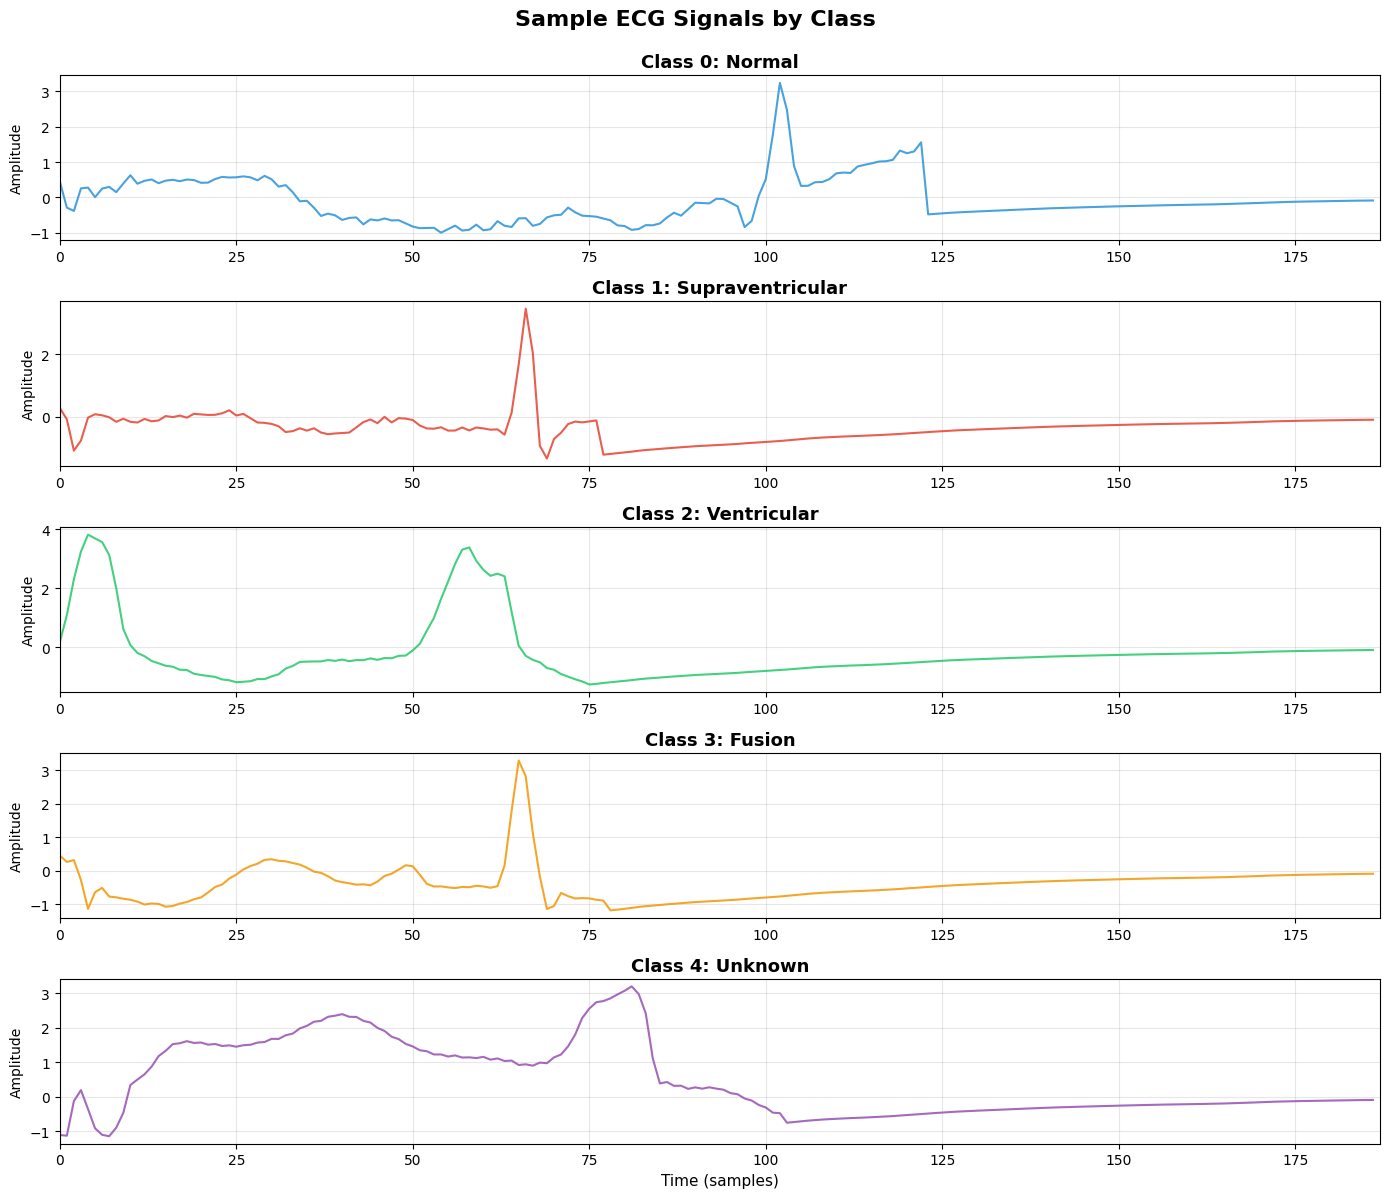

✅ ECG signal visualization complete


In [7]:
# Visualize one sample from each class
fig, axes = plt.subplots(5, 1, figsize=(14, 12))

for i, (ax, class_name) in enumerate(zip(axes, class_names)):
    # Find first sample of each class
    idx = np.where(y_train == i)[0][0]
    signal = X_train[idx].squeeze()

    # Plot
    ax.plot(signal, linewidth=1.5, color=colors[i], alpha=0.9)
    ax.set_title(f'Class {i}: {class_name}', fontsize=13, fontweight='bold')
    ax.set_ylabel('Amplitude', fontsize=10)
    ax.grid(alpha=0.3)
    ax.set_xlim(0, 187)

    if i == 4:  # Last subplot
        ax.set_xlabel('Time (samples)', fontsize=11)

plt.suptitle('Sample ECG Signals by Class', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✅ ECG signal visualization complete")

# BASELINE - KNN

KNN BASELINE MODEL

Before training the complex CNN-LSTM model, let's establish a baseline
using a simple K-Nearest Neighbors classifier for comparison.

📊 Preparing data for KNN...
Train shape: (74420, 187)
Val shape: (13134, 187)
Test shape: (21892, 187)

🔧 Normalizing with RobustScaler...

🤖 Training KNN classifier (k=5, Manhattan distance)...
✓ Training completed in 0.09s

KNN BASELINE RESULTS


  File "c:\Users\Ram Narayan Jaiswal\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\Ram Narayan Jaiswal\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ram Narayan Jaiswal\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1036, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_ne


Train Set:
  Accuracy: 0.9811
  F1 (macro): 0.9065
  F1 (weighted): 0.9804

Validation Set:
  Accuracy: 0.9769
  F1 (macro): 0.8797
  F1 (weighted): 0.9760

Test Set:
  Accuracy: 0.9743
  F1 (macro): 0.8672
  F1 (weighted): 0.9731

📋 Detailed Test Set Classification Report:
                  precision    recall  f1-score   support

          Normal     0.9784    0.9945    0.9864     18118
Supraventricular     0.8853    0.6385    0.7419       556
     Ventricular     0.9410    0.9040    0.9222      1448
          Fusion     0.7939    0.6420    0.7099       162
         Unknown     0.9929    0.9590    0.9756      1608

        accuracy                         0.9743     21892
       macro avg     0.9183    0.8276    0.8672     21892
    weighted avg     0.9733    0.9743    0.9731     21892


📊 Generating KNN confusion matrix...


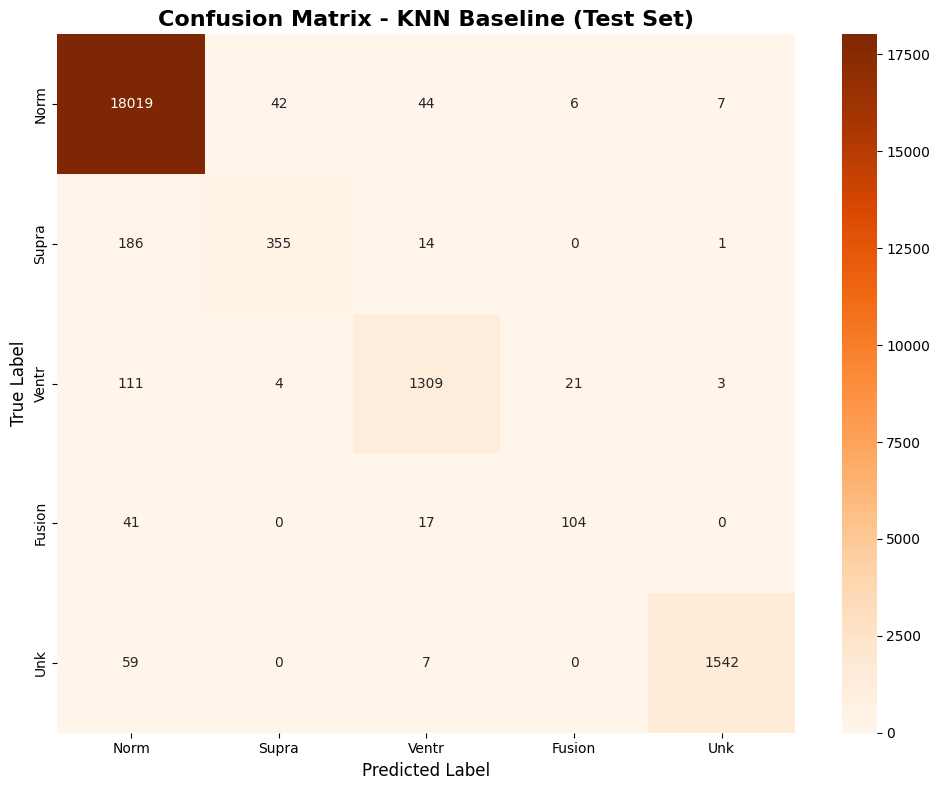

✓ Saved: results/confusion_matrix_knn_baseline.png
✓ Saved: results/knn_baseline_results.csv

KNN BASELINE ESTABLISHED

💡 Key Insight:
This simple KNN baseline will be compared against the CNN-LSTM model
to demonstrate the value of deep learning for ECG signal classification.

Now proceeding to train the advanced CNN-LSTM model...


In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler

print("=" * 80)
print("KNN BASELINE MODEL")
print("=" * 80)
print("\nBefore training the complex CNN-LSTM model, let's establish a baseline")
print("using a simple K-Nearest Neighbors classifier for comparison.")

# Prepare data for KNN (flatten to 2D)
print("\n📊 Preparing data for KNN...")

# Use ORIGINAL data (before augmentation) for fair comparison
X_train_knn = X_train[:len(y_train)].reshape(len(y_train), -1)  # Flatten to (n, 187)
y_train_knn = y_train[:len(y_train)]

X_val_knn = X_val.reshape(X_val.shape[0], -1)
X_test_knn = X_test.reshape(X_test.shape[0], -1)

print(f"Train shape: {X_train_knn.shape}")
print(f"Val shape: {X_val_knn.shape}")
print(f"Test shape: {X_test_knn.shape}")

# Normalize with RobustScaler (better for outliers)
print("\n🔧 Normalizing with RobustScaler...")
knn_scaler = RobustScaler()
X_train_knn_scaled = knn_scaler.fit_transform(X_train_knn)
X_val_knn_scaled = knn_scaler.transform(X_val_knn)
X_test_knn_scaled = knn_scaler.transform(X_test_knn)

# Train KNN classifier
print("\n🤖 Training KNN classifier (k=5, Manhattan distance)...")
start_time = time.time()

knn = KNeighborsClassifier(n_neighbors=5, metric='manhattan', n_jobs=-1)
knn.fit(X_train_knn_scaled, y_train_knn)

train_time = time.time() - start_time
print(f"✓ Training completed in {train_time:.2f}s")

# Evaluate on all three sets
print("\n" + "=" * 80)
print("KNN BASELINE RESULTS")
print("=" * 80)

knn_results = {}

for dataset_name, X_data, y_data in [
    ('Train', X_train_knn_scaled, y_train_knn),
    ('Validation', X_val_knn_scaled, y_val),
    ('Test', X_test_knn_scaled, y_test)
]:
    y_pred_knn = knn.predict(X_data)

    acc = accuracy_score(y_data, y_pred_knn)
    f1_macro = f1_score(y_data, y_pred_knn, average='macro')
    f1_weighted = f1_score(y_data, y_pred_knn, average='weighted')

    knn_results[dataset_name] = {
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }

    print(f"\n{dataset_name} Set:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  F1 (macro): {f1_macro:.4f}")
    print(f"  F1 (weighted): {f1_weighted:.4f}")

# Detailed test set report
print("\n📋 Detailed Test Set Classification Report:")
y_test_pred_knn = knn.predict(X_test_knn_scaled)
print(classification_report(y_test, y_test_pred_knn, target_names=class_names, digits=4))

# Visualize KNN confusion matrix
print("\n📊 Generating KNN confusion matrix...")
cm_knn = confusion_matrix(y_test, y_test_pred_knn)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Norm', 'Supra', 'Ventr', 'Fusion', 'Unk'],
            yticklabels=['Norm', 'Supra', 'Ventr', 'Fusion', 'Unk'])
plt.title('Confusion Matrix - KNN Baseline (Test Set)', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('results/confusion_matrix_knn_baseline.png', dpi=300)
plt.show()

print("✓ Saved: results/confusion_matrix_knn_baseline.png")

# Save KNN baseline results
knn_results_df = pd.DataFrame(knn_results).T
knn_results_df.to_csv('results/knn_baseline_results.csv')
print("✓ Saved: results/knn_baseline_results.csv")

print("\n" + "=" * 80)
print("KNN BASELINE ESTABLISHED")
print("=" * 80)
print("\n💡 Key Insight:")
print("This simple KNN baseline will be compared against the CNN-LSTM model")
print("to demonstrate the value of deep learning for ECG signal classification.")
print("\nNow proceeding to train the advanced CNN-LSTM model...")

## 2. Data Augmentation Strategy

To address the severe class imbalance, we implemented aggressive data augmentation for minority classes. We applied **4 different augmentation techniques**:

### Augmentation Techniques

1. **Time Warping** (α = 0.85-1.15)
   - Stretches or compresses the signal in time domain
   - Simulates variations in heart rate

2. **Jittering** (σ = 0.03-0.04)
   - Adds Gaussian noise to the signal
   - Simulates measurement noise and artifacts

3. **Magnitude Scaling**
   - Randomly scales signal amplitude
   - Simulates different electrode placements

4. **Combined Approach**
   - Applies multiple techniques simultaneously
   - Creates more diverse augmented samples

### Augmentation Multipliers
- **Supraventricular:** 6x (1,889 → 13,223 samples)
- **Ventricular:** 3x (4,920 → 19,680 samples)
- **Fusion:** 15x (545 → 8,720 samples) - most aggressive
- **Unknown:** 1x (5,466 → 10,932 samples)
- **Normal:** No augmentation (already majority class)

**Result:** Training set increased from 74,420 to 114,155 samples (+53%)

In [9]:
# ==================== CELL 3: DATA AUGMENTATION ====================

def augment_ecg_aggressive(X, y, target_class, n_augment):
    """
    Aggressive augmentation with multiple techniques for a specific class.

    Techniques:
    - Time warping: Stretch/compress signals temporally
    - Jittering: Add random noise
    - Scaling: Multiply by random factors
    - Rolling: Shift signals in time
    """
    class_mask = (y == target_class)
    class_samples = X[class_mask]

    augmented_X = []
    augmented_y = []

    for _ in range(n_augment):
        for sample in class_samples:
            sample_flat = sample.squeeze()
            aug_type = np.random.randint(0, 4)

            if aug_type == 0:  # Time warping
                alpha = np.random.uniform(0.85, 1.15)
                new_length = int(187 * alpha)
                warped = np.interp(
                    np.linspace(0, 187, new_length),
                    np.arange(187),
                    sample_flat
                )
                if len(warped) < 187:
                    warped = np.pad(warped, (0, 187 - len(warped)), mode='edge')
                else:
                    warped = warped[:187]
                augmented = warped

            elif aug_type == 1:  # Jittering + Rolling
                start = np.random.randint(0, 10)
                sliced = np.roll(sample_flat, -start)
                noise = np.random.normal(0, 0.04, 187)
                augmented = sliced + noise

            elif aug_type == 2:  # Smooth scaling
                smooth = np.random.uniform(0.5, 2.0, 187)
                smooth = np.convolve(smooth, np.ones(10)/10, mode='same')
                augmented = sample_flat * smooth

            else:  # Combined: warping + noise + scaling
                alpha = np.random.uniform(0.9, 1.1)
                new_length = int(187 * alpha)
                warped = np.interp(
                    np.linspace(0, 187, new_length),
                    np.arange(187),
                    sample_flat
                )
                if len(warped) < 187:
                    warped = np.pad(warped, (0, 187 - len(warped)), mode='edge')
                else:
                    warped = warped[:187]
                noise = np.random.normal(0, 0.03, 187)
                scale = np.random.uniform(0.9, 1.1)
                augmented = (warped + noise) * scale

            augmented_X.append(augmented.reshape(1, 187))
            augmented_y.append(target_class)

    return np.array(augmented_X), np.array(augmented_y)

# Apply data augmentation
print("=" * 60)
print("PERFORMING DATA AUGMENTATION")
print("=" * 60)

aug_X_list, aug_y_list = [X_train], [y_train]

# Augment minority classes
print("\nAugmenting minority classes...")

# Supraventricular (class 1) - 6x
aug_X, aug_y = augment_ecg_aggressive(X_train, y_train, target_class=1, n_augment=6)
aug_X_list.append(aug_X)
aug_y_list.append(aug_y)
print(f"  ✓ Supraventricular: +{len(aug_X):,} samples")

# Fusion (class 3) - 15x
aug_X, aug_y = augment_ecg_aggressive(X_train, y_train, target_class=3, n_augment=15)
aug_X_list.append(aug_X)
aug_y_list.append(aug_y)
print(f"  ✓ Fusion: +{len(aug_X):,} samples")

# Ventricular (class 2) - 3x
aug_X, aug_y = augment_ecg_aggressive(X_train, y_train, target_class=2, n_augment=3)
aug_X_list.append(aug_X)
aug_y_list.append(aug_y)
print(f"  ✓ Ventricular: +{len(aug_X):,} samples")

# Unknown (class 4) - 1x
aug_X, aug_y = augment_ecg_aggressive(X_train, y_train, target_class=4, n_augment=1)
aug_X_list.append(aug_X)
aug_y_list.append(aug_y)
print(f"  ✓ Unknown: +{len(aug_X):,} samples")

# Combine all augmented data
X_train = np.vstack(aug_X_list)
y_train = np.hstack(aug_y_list)

print(f"\n✓ Final training set shape: {X_train.shape}")
print(f"\n📊 Class distribution after augmentation:")
for i, name in enumerate(class_names):
    count = (y_train == i).sum()
    print(f"  {name}: {count:,}")


PERFORMING DATA AUGMENTATION

Augmenting minority classes...
  ✓ Supraventricular: +11,334 samples
  ✓ Fusion: +8,175 samples
  ✓ Ventricular: +14,760 samples
  ✓ Unknown: +5,466 samples

✓ Final training set shape: (114155, 1, 187)

📊 Class distribution after augmentation:
  Normal: 61,600
  Supraventricular: 13,223
  Ventricular: 19,680
  Fusion: 8,720
  Unknown: 10,932


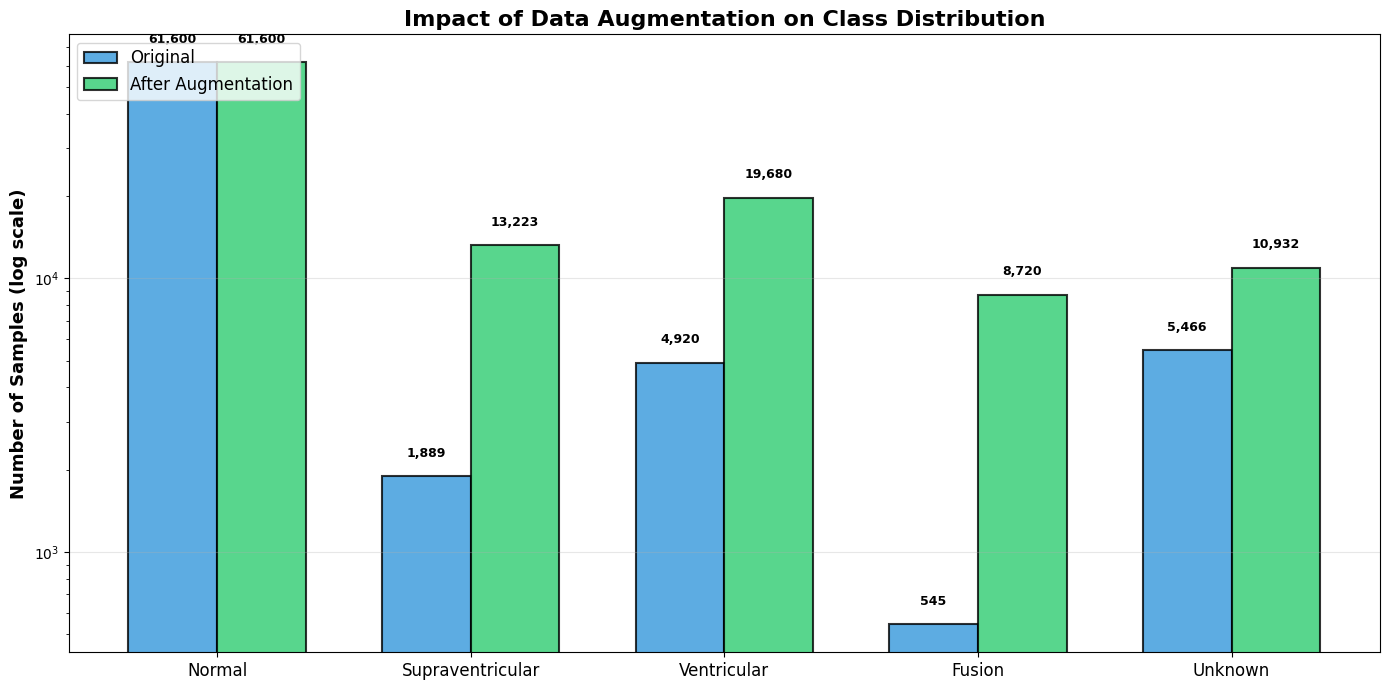

📊 Augmentation Impact:

Class                    Original    Augmented     Increase
------------------------------------------------------------
Normal                     61,600       61,600           0%
Supraventricular            1,889       13,223         600%
Ventricular                 4,920       19,680         300%
Fusion                        545        8,720        1500%
Unknown                     5,466       10,932         100%
------------------------------------------------------------
Total                      74,420      114,155          53%


In [10]:
# For demonstration, show the final augmented distribution
# (Load from your saved augmented data or display theoretical counts)

augmented_counts = [61600, 13223, 19680, 8720, 10932]

fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(class_names))
width = 0.35

bars1 = ax.bar(x - width/2, original_counts, width, label='Original',
               color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, augmented_counts, width, label='After Augmentation',
               color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_ylabel('Number of Samples (log scale)', fontsize=13, fontweight='bold')
ax.set_title('Impact of Data Augmentation on Class Distribution',
             fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names, fontsize=12)
ax.legend(fontsize=12, loc='upper left')
ax.set_yscale('log')
ax.grid(axis='y', alpha=0.3)

# Add values on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height * 1.15,
                f'{int(height):,}', ha='center', va='bottom',
                fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Print statistics
print("📊 Augmentation Impact:\n")
print(f"{'Class':<20} {'Original':>12} {'Augmented':>12} {'Increase':>12}")
print("-" * 60)
for i, name in enumerate(class_names):
    increase = ((augmented_counts[i] - original_counts[i]) / original_counts[i] * 100)
    print(f"{name:<20} {original_counts[i]:>12,} {augmented_counts[i]:>12,} {increase:>11.0f}%")
print("-" * 60)
print(f"{'Total':<20} {sum(original_counts):>12,} {sum(augmented_counts):>12,} "
      f"{((sum(augmented_counts) - sum(original_counts)) / sum(original_counts) * 100):>11.0f}%")


## 3. Model Architecture: CNN-LSTM Hybrid

We developed a deep hybrid architecture combining:
- **Convolutional layers** for spatial feature extraction
- **LSTM layers** for temporal pattern recognition
- **Attention mechanism** for focusing on important features

### Architecture Components

#### 1. CNN Layers (4 layers)
- **Conv1:** 1 → 64 channels (kernel=7)
- **Conv2:** 64 → 128 channels (kernel=5)
- **Conv3:** 128 → 256 channels (kernel=3)
- **Conv4:** 256 → 512 channels (kernel=3)
- Each followed by BatchNorm + ReLU + MaxPooling

#### 2. LSTM Layers
- **2 Bidirectional LSTM layers**
- Hidden size: 192 units
- Dropout: 0.45
- Output: 384 features (192 × 2 directions)

#### 3. Attention Mechanism
- Soft attention over LSTM outputs
- Learns to focus on discriminative temporal regions

#### 4. Fully Connected Layers
- FC1: 384 → 256
- FC2: 256 → 128
- FC3: 128 → 64
- FC4: 64 → 5 (output classes)
- Dropout (0.45) + BatchNorm between layers

**Total Parameters:** ~3.2 million


In [11]:
# Focal Loss for handling class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.5, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss

# CNN-LSTM Deep Model with Attention
class ECG_CNN_LSTM_Deep(nn.Module):
    def __init__(self, num_classes=5, dropout=0.45):
        super(ECG_CNN_LSTM_Deep, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv1d(1, 64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2, 2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2, 2)

        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(2, 2)

        self.conv4 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(512)

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=512,
            hidden_size=192,
            num_layers=2,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )

        # Attention mechanism
        self.attention = nn.Linear(384, 1)

        # Fully connected layers
        self.dropout1 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(384, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)

        self.dropout2 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(256, 128)
        self.bn_fc2 = nn.BatchNorm1d(128)

        self.dropout3 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(128, 64)
        self.bn_fc3 = nn.BatchNorm1d(64)

        self.dropout4 = nn.Dropout(dropout)
        self.fc4 = nn.Linear(64, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        # CNN layers
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = self.relu(self.bn4(self.conv4(x)))

        # Prepare for LSTM
        x = x.transpose(1, 2)  # (batch, length, features)

        # LSTM + Attention
        lstm_out, _ = self.lstm(x)
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attention_weights * lstm_out, dim=1)

        # Fully connected layers
        x = self.dropout1(context)
        x = self.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout2(x)
        x = self.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout3(x)
        x = self.relu(self.bn_fc3(self.fc3(x)))
        x = self.dropout4(x)
        x = self.fc4(x)

        return x

# Prepare data for training
print("=" * 60)
print("PREPARING DATA LOADERS")
print("=" * 60)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Calculate class weights for Focal Loss
class_counts = np.bincount(y_train)
class_weights = np.power(1.0 / class_counts, 0.45)
class_weights = class_weights / class_weights.sum() * len(class_counts)
class_weights_tensor = torch.FloatTensor(class_weights)

print(f"Class weights: {class_weights_tensor}")

# Weighted random sampler for balanced batches
sample_weights = [class_weights[int(label)] for label in y_train]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print("✓ Data loaders created")

# Setup device and model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

model = ECG_CNN_LSTM_Deep(num_classes=5, dropout=0.45)
model = model.to(device)

class_weights_tensor = class_weights_tensor.to(device)
criterion = FocalLoss(alpha=class_weights_tensor, gamma=2.5)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=2e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

print("✓ Model, loss, and optimizer initialized")
print(f"\nModel parameters: {sum(p.numel() for p in model.parameters()):,}")

PREPARING DATA LOADERS
Class weights: tensor([0.5401, 1.0795, 0.9026, 1.3019, 1.1759])
✓ Data loaders created

Using device: cpu
✓ Model, loss, and optimizer initialized

Model parameters: 2,649,350


## 4. Training Configuration

### Loss Function: Focal Loss
We use Focal Loss instead of standard Cross-Entropy to better handle class imbalance:

$$\text{FL}(p_t) = -\alpha_t (1 - p_t)^\gamma \log(p_t)$$

Where:
- $\alpha_t$ = class weights (inverse frequency based)
- $\gamma = 2.5$ (focusing parameter)

**Benefits:**
- Down-weights easy examples (well-classified)
- Focuses on hard, misclassified examples
- Particularly effective for minority classes

### Optimizer & Scheduler
- **Optimizer:** AdamW (lr=0.0008, weight_decay=2e-5)
- **Scheduler:** ReduceLROnPlateau (factor=0.5, patience=5)
- **Gradient Clipping:** max_norm=1.0

### Training Parameters
- **Batch size:** 128
- **Max epochs:** 50
- **Early stopping:** patience=10 (monitors validation F1)
- **Final epoch:** 42 (early stopped)


In [12]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro')

    return avg_loss, accuracy, f1_macro

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, accuracy, f1_macro, f1_weighted, all_labels, all_preds

# Training loop
print("=" * 80)
print("STARTING TRAINING - CNN-LSTM DEEP MODEL")
print("=" * 80)

num_epochs = 50
best_f1 = 0.0
patience_counter = 0
patience = 10

train_losses, train_accs, train_f1s = [], [], []
val_losses, val_accs, val_f1s = [], [], []

start_time = time.time()

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc, train_f1 = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc, val_f1_macro, val_f1_weighted, _, _ = evaluate(model, val_loader, criterion, device)

    # Learning rate scheduling
    scheduler.step(val_f1_macro)

    # Save best model
    if val_f1_macro > best_f1:
        best_f1 = val_f1_macro
        torch.save(model.state_dict(), 'models/best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1

    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_f1s.append(train_f1)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1_macro)

    # Print progress
    print(f"Epoch [{epoch+1:2d}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1_macro:.4f} "
          f"F1-weighted: {val_f1_weighted:.4f}")

    # Early stopping
    if patience_counter >= patience:
        print(f"\n⚠ Early stopping at epoch {epoch + 1}")
        break

training_time = time.time() - start_time
print(f"\n✓ Training completed in {training_time:.2f}s ({training_time/60:.1f} minutes)")
print(f"✓ Best validation F1 (macro): {best_f1:.4f}")

# Load best model for evaluation
model.load_state_dict(torch.load('models/best_model.pth'))

# Final evaluation on test set
print("\n" + "=" * 80)
print("FINAL EVALUATION ON TEST SET")
print("=" * 80)

test_loss, test_acc, test_f1_macro, test_f1_weighted, y_true, y_pred = evaluate(
    model, test_loader, criterion, device
)

print(f"\n📊 Test Results:")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  F1 (macro): {test_f1_macro:.4f}")
print(f"  F1 (weighted): {test_f1_weighted:.4f}")

print(f"\n📋 Per-class Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

print("🎉 TRAINING AND EVALUATION COMPLETED!")

STARTING TRAINING - CNN-LSTM DEEP MODEL
Epoch [ 1/50] | Train Loss: 0.1671 Acc: 0.7233 F1: 0.7461 | Val Loss: 0.0401 Acc: 0.8718 F1: 0.6722 F1-weighted: 0.9038
Epoch [ 2/50] | Train Loss: 0.0635 Acc: 0.8879 F1: 0.8925 | Val Loss: 0.0290 Acc: 0.8131 F1: 0.6515 F1-weighted: 0.8669
Epoch [ 3/50] | Train Loss: 0.0407 Acc: 0.9141 F1: 0.9176 | Val Loss: 0.0204 Acc: 0.8881 F1: 0.7066 F1-weighted: 0.9128
Epoch [ 4/50] | Train Loss: 0.0338 Acc: 0.9216 F1: 0.9244 | Val Loss: 0.0146 Acc: 0.9436 F1: 0.7820 F1-weighted: 0.9524
Epoch [ 5/50] | Train Loss: 0.0277 Acc: 0.9323 F1: 0.9345 | Val Loss: 0.0160 Acc: 0.9636 F1: 0.8462 F1-weighted: 0.9664
Epoch [ 6/50] | Train Loss: 0.0234 Acc: 0.9401 F1: 0.9420 | Val Loss: 0.0149 Acc: 0.9565 F1: 0.8472 F1-weighted: 0.9602
Epoch [ 7/50] | Train Loss: 0.0211 Acc: 0.9447 F1: 0.9466 | Val Loss: 0.0275 Acc: 0.8168 F1: 0.6522 F1-weighted: 0.8680
Epoch [ 8/50] | Train Loss: 0.0187 Acc: 0.9507 F1: 0.9522 | Val Loss: 0.0169 Acc: 0.9104 F1: 0.7884 F1-weighted: 0.9308


GENERATING ADDITIONAL METRICS AND VISUALIZATIONS

📊 Creating clean data loaders for evaluation...
Evaluating on all three datasets...

METRICS COMPARISON: TRAIN / VALIDATION / TEST

Train Set:
  Accuracy: 0.9974
  F1 (macro): 0.9964
  F1 (weighted): 0.9974
  Samples: 114,155

Validation Set:
  Accuracy: 0.9875
  F1 (macro): 0.9310
  F1 (weighted): 0.9876
  Samples: 13,134

Test Set:
  Accuracy: 0.9871
  F1 (macro): 0.9280
  F1 (weighted): 0.9871
  Samples: 21,892

📋 Summary Table:
   Dataset Accuracy F1 (macro) F1 (weighted)  Samples
     Train   0.9974     0.9964        0.9974   114155
Validation   0.9875     0.9310        0.9876    13134
      Test   0.9871     0.9280        0.9871    21892

✓ Saved: results/metrics_summary_all_sets.csv

PER-CLASS CLASSIFICATION REPORTS

📋 Train Set:
                  precision    recall  f1-score   support

          Normal     0.9996    0.9974    0.9985     61600
Supraventricular     0.9928    0.9991    0.9959     13223
     Ventricular     0.9984 

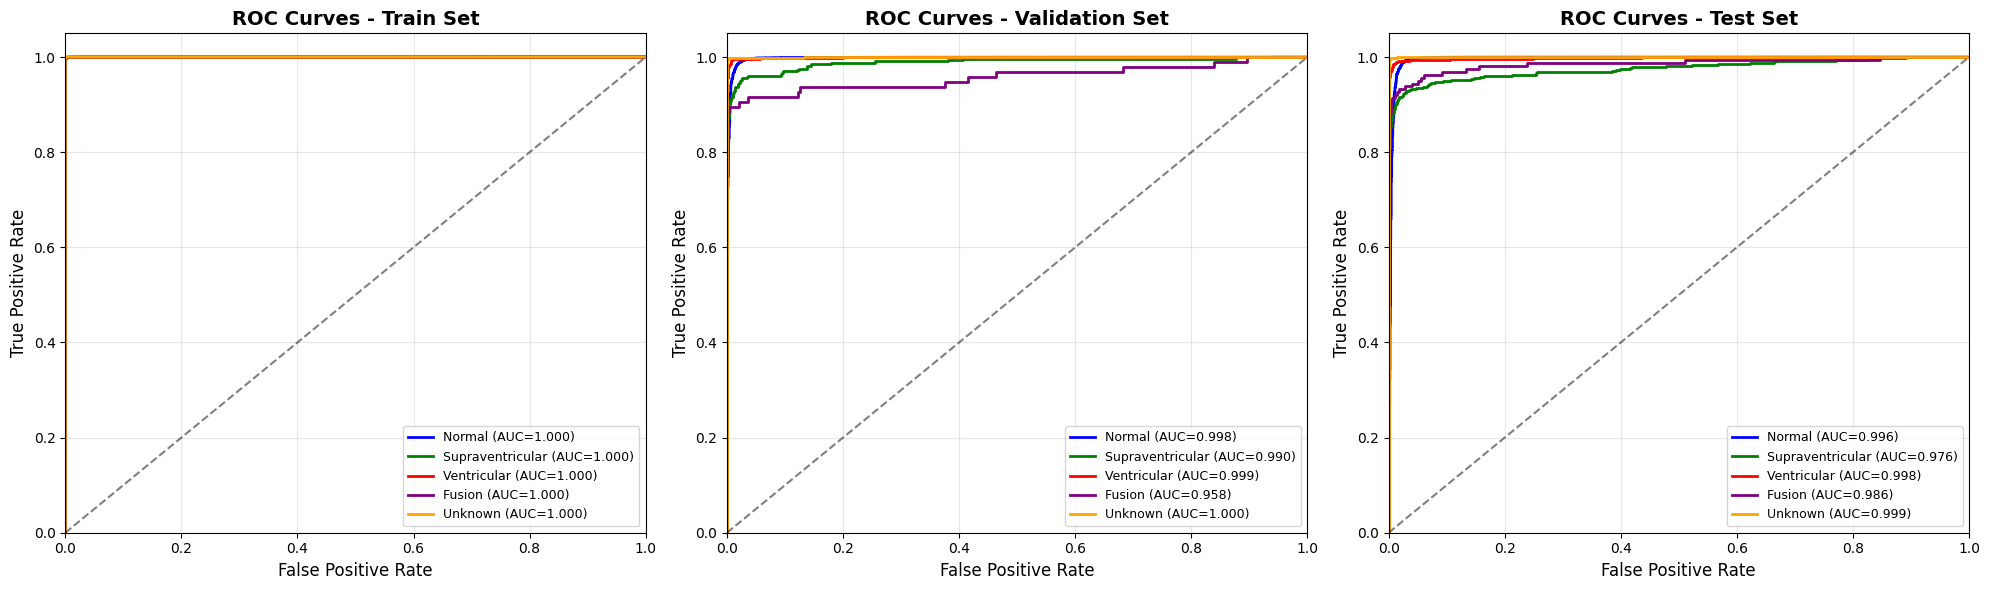

✓ Saved: results/roc_curves_all_sets.png

GENERATING PRECISION-RECALL CURVES


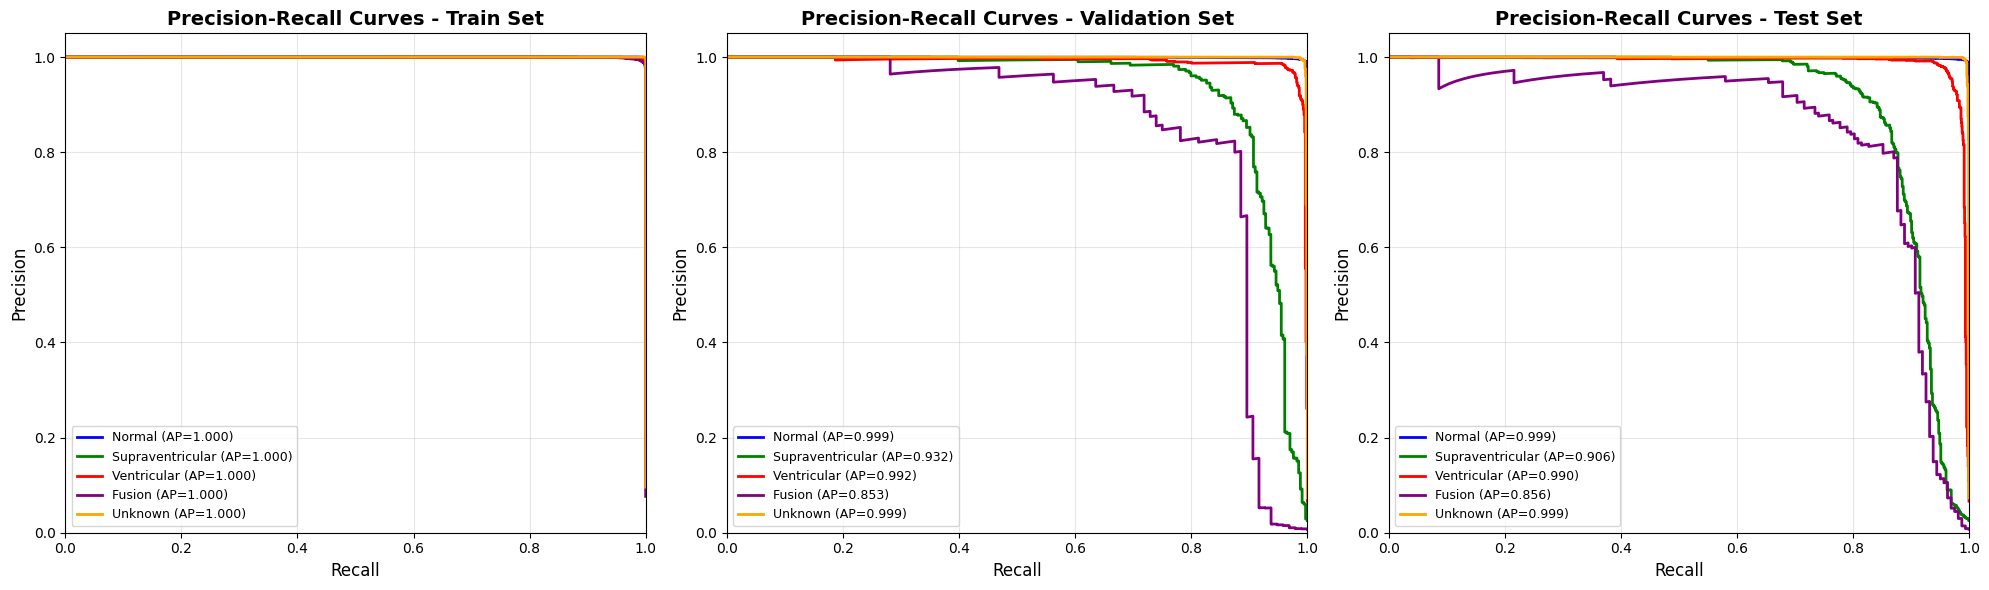

✓ Saved: results/precision_recall_curves_all_sets.png

GENERATING PER-CLASS METRICS COMPARISON


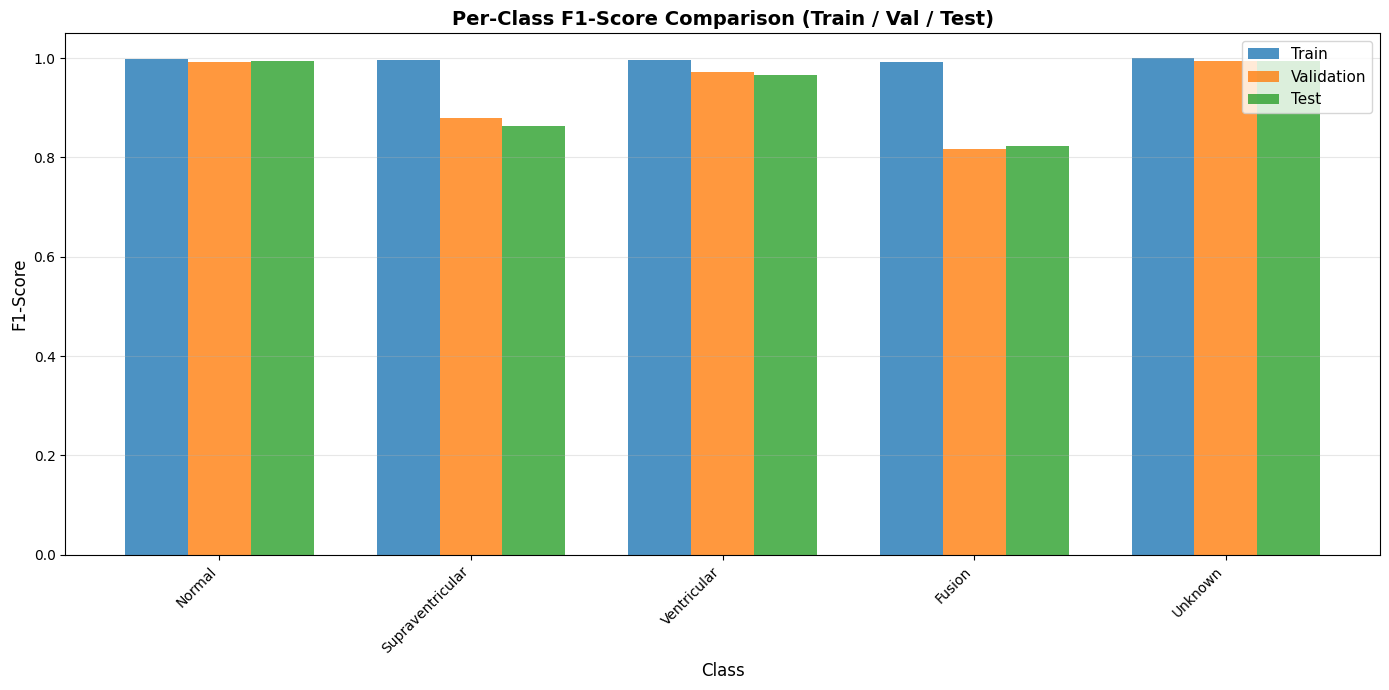

✓ Saved: results/per_class_f1_comparison.png
✓ Saved: results/per_class_metrics_all_sets.csv

GENERATING CONFUSION MATRICES FOR ALL SETS


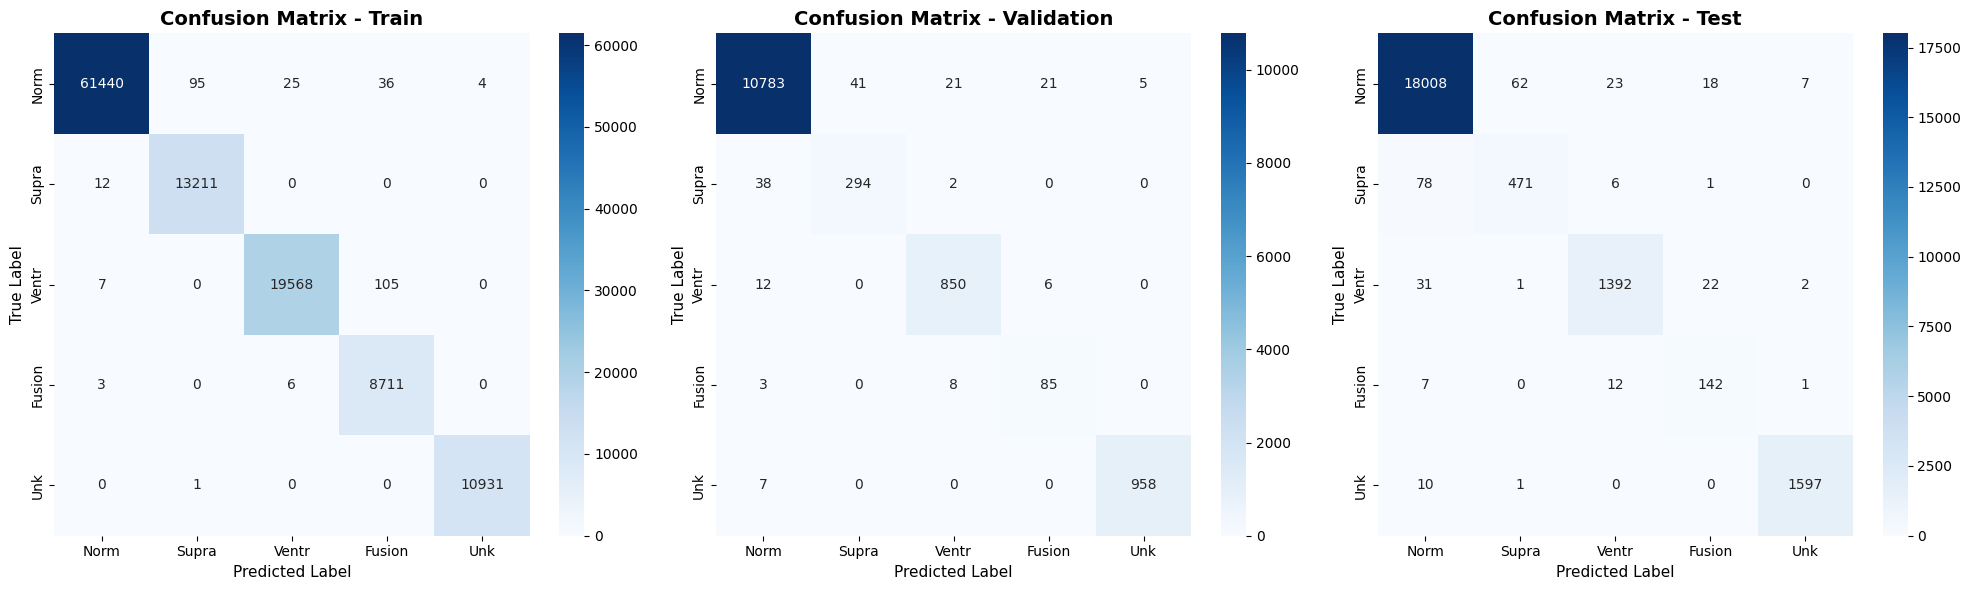

✓ Saved: results/confusion_matrices_all_sets.png

🎉 ALL ADDITIONAL VISUALIZATIONS COMPLETED!

📁 Generated files:
  ✓ results/metrics_summary_all_sets.csv
  ✓ results/roc_curves_all_sets.png
  ✓ results/precision_recall_curves_all_sets.png
  ✓ results/per_class_f1_comparison.png
  ✓ results/per_class_metrics_all_sets.csv
  ✓ results/confusion_matrices_all_sets.png


In [14]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

print("=" * 80)
print("GENERATING ADDITIONAL METRICS AND VISUALIZATIONS")
print("=" * 80)

# Create clean data loaders WITHOUT sampling for evaluation
print("\n📊 Creating clean data loaders for evaluation...")
train_loader_eval = DataLoader(train_dataset, batch_size=128, shuffle=False)
val_loader_eval = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader_eval = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Load best model
model.load_state_dict(torch.load('models/best_model.pth'))
model.eval()

# Helper function to get predictions with probabilities
def get_predictions_with_probs(model, loader, device):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

# Get predictions for all three sets
print("Evaluating on all three datasets...")
y_train_true, y_train_pred, y_train_probs = get_predictions_with_probs(model, train_loader_eval, device)
y_val_true, y_val_pred, y_val_probs = get_predictions_with_probs(model, val_loader_eval, device)
y_test_true, y_test_pred, y_test_probs = get_predictions_with_probs(model, test_loader_eval, device)

# Calculate metrics for all sets
datasets = {
    'Train': (y_train_true, y_train_pred, y_train_probs),
    'Validation': (y_val_true, y_val_pred, y_val_probs),
    'Test': (y_test_true, y_test_pred, y_test_probs)
}

print("\n" + "=" * 80)
print("METRICS COMPARISON: TRAIN / VALIDATION / TEST")
print("=" * 80)

metrics_summary = []
                  
for dataset_name, (y_true, y_pred, y_probs) in datasets.items():
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    metrics_summary.append({
        'Dataset': dataset_name,
        'Accuracy': f'{acc:.4f}',
        'F1 (macro)': f'{f1_macro:.4f}',
        'F1 (weighted)': f'{f1_weighted:.4f}',
        'Samples': len(y_true)
    })

    print(f"\n{dataset_name} Set:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  F1 (macro): {f1_macro:.4f}")
    print(f"  F1 (weighted): {f1_weighted:.4f}")
    print(f"  Samples: {len(y_true):,}")

# Create summary table
summary_df = pd.DataFrame(metrics_summary)
print("\n📋 Summary Table:")
print(summary_df.to_string(index=False))
summary_df.to_csv('results/metrics_summary_all_sets.csv', index=False)
print("\n✓ Saved: results/metrics_summary_all_sets.csv")

# Print per-class reports for all sets
print("\n" + "=" * 80)
print("PER-CLASS CLASSIFICATION REPORTS")
print("=" * 80)

for dataset_name, (y_true, y_pred, _) in datasets.items():
    print(f"\n📋 {dataset_name} Set:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# ==================== ROC CURVES ====================
print("\n" + "=" * 80)
print("GENERATING ROC CURVES")
print("=" * 80)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
dataset_names = ['Train', 'Validation', 'Test']
colors = ['blue', 'green', 'red', 'purple', 'orange']

for idx, (dataset_name, (y_true, y_pred, y_probs)) in enumerate(datasets.items()):
    ax = axes[idx]

    # Binarize labels for multi-class ROC
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])

    # Plot ROC curve for each class
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f'{class_name} (AUC={roc_auc:.3f})',
                linewidth=2, color=colors[i])

    # Plot diagonal
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(f'ROC Curves - {dataset_name} Set', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/roc_curves_all_sets.png', dpi=300)
plt.show()
print("✓ Saved: results/roc_curves_all_sets.png")

# ==================== PRECISION-RECALL CURVES ====================
print("\n" + "=" * 80)
print("GENERATING PRECISION-RECALL CURVES")
print("=" * 80)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (dataset_name, (y_true, y_pred, y_probs)) in enumerate(datasets.items()):
    ax = axes[idx]

    # Binarize labels
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])

    # Plot PR curve for each class
    for i, class_name in enumerate(class_names):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
        avg_precision = average_precision_score(y_true_bin[:, i], y_probs[:, i])
        ax.plot(recall, precision, label=f'{class_name} (AP={avg_precision:.3f})',
                linewidth=2, color=colors[i])

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title(f'Precision-Recall Curves - {dataset_name} Set', fontsize=14, fontweight='bold')
    ax.legend(loc='lower left', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/precision_recall_curves_all_sets.png', dpi=300)
plt.show()
print("✓ Saved: results/precision_recall_curves_all_sets.png")

# ==================== PER-CLASS METRICS COMPARISON ====================
print("\n" + "=" * 80)
print("GENERATING PER-CLASS METRICS COMPARISON")
print("=" * 80)

from sklearn.metrics import precision_score, recall_score

# Collect per-class metrics for all datasets
per_class_data = []

for dataset_name, (y_true, y_pred, y_probs) in datasets.items():
    for class_idx, class_name in enumerate(class_names):
        # Binary classification: class vs rest
        y_true_binary = (y_true == class_idx).astype(int)
        y_pred_binary = (y_pred == class_idx).astype(int)

        precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
        recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
        f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)
        support = (y_true == class_idx).sum()

        per_class_data.append({
            'Dataset': dataset_name,
            'Class': class_name,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Support': support
        })

per_class_df = pd.DataFrame(per_class_data)

# Visualize per-class F1 scores
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(class_names))
width = 0.25

for idx, dataset_name in enumerate(['Train', 'Validation', 'Test']):
    dataset_metrics = per_class_df[per_class_df['Dataset'] == dataset_name]
    f1_scores = dataset_metrics['F1-Score'].values
    ax.bar(x + idx * width, f1_scores, width,
           label=dataset_name, alpha=0.8)

ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('Per-Class F1-Score Comparison (Train / Val / Test)', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.05])
plt.tight_layout()
plt.savefig('results/per_class_f1_comparison.png', dpi=300)
plt.show()
print("✓ Saved: results/per_class_f1_comparison.png")

# Save per-class metrics to CSV
per_class_df.to_csv('results/per_class_metrics_all_sets.csv', index=False)
print("✓ Saved: results/per_class_metrics_all_sets.csv")

# ==================== CONFUSION MATRICES FOR ALL SETS ====================
print("\n" + "=" * 80)
print("GENERATING CONFUSION MATRICES FOR ALL SETS")
print("=" * 80)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (dataset_name, (y_true, y_pred, _)) in enumerate(datasets.items()):
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Norm', 'Supra', 'Ventr', 'Fusion', 'Unk'],
                yticklabels=['Norm', 'Supra', 'Ventr', 'Fusion', 'Unk'])
    axes[idx].set_title(f'Confusion Matrix - {dataset_name}', fontsize=14, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=11)
    axes[idx].set_xlabel('Predicted Label', fontsize=11)

plt.tight_layout()
plt.savefig('results/confusion_matrices_all_sets.png', dpi=300)
plt.show()
print("✓ Saved: results/confusion_matrices_all_sets.png")

print("\n" + "=" * 80)
print("🎉 ALL ADDITIONAL VISUALIZATIONS COMPLETED!")
print("=" * 80)
print("\n📁 Generated files:")
print("  ✓ results/metrics_summary_all_sets.csv")
print("  ✓ results/roc_curves_all_sets.png")
print("  ✓ results/precision_recall_curves_all_sets.png")
print("  ✓ results/per_class_f1_comparison.png")
print("  ✓ results/per_class_metrics_all_sets.csv")
print("  ✓ results/confusion_matrices_all_sets.png")
